# **Business problem**

My company produces footwear and sells them online. There has been complaints from customers that they recieve the wrong type of footwear and they return the footwears. This reduces the sales. As the data scientist my job is to design a system to enhance customer experience and boost sales as well as improve operational efficiency.


**Benefits to the company**

* Identify the right type of footwearfor customers and improve sales.
* Improve the accuracy in footwear categorization.
* Reduce returns and and improve customer satisfation.

**Formulating it as ML**

 It involves the use of skills like statistics,Python,tensorflow etc.Based on the images of the footwear this task will be approached using CNN which can be used to
*   Determine the categories of footwear.
*   Recommend similar footwear based on customer preference.
*   Detect defects from normal samples

Data is collected from Kaggle






# **Loading libraries**

In [ ]:
import pandas as pd
import numpy as np
!pip install split-folders
import splitfolders
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from zipfile import ZipFile
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models


# **Loading the dataset**

In [ ]:
!unzip -q archive.zip -d ./
dataset_path = './dataset'


The dataset is extracted and unzipped.

In [ ]:
dataset_path = os.path.abspath('./dataset')
print(f"Dataset path: {dataset_path}")


Dataset path: /content/dataset


A path to access the data is created

# **Splitting the data**

In [ ]:
main_folder = "./Shoe vs Sandal vs Boot Dataset"

subset_folder = "./Shoe vs Sandal vs Boot Dataset"

splitfolders.ratio(
    main_folder,
    output=subset_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)

Copying files: 15000 files [00:02, 6271.89 files/s]


A main directory is created to contain the dataset and an subset directory is created to contain the split data.
The dataset contains 15,000 images.The data is split into train which contains 80% of the data and 20% for val

In [ ]:
val_folder = os.path.join(subset_folder, 'val')
test_folder = os.path.join(subset_folder, 'test')
os.rename(val_folder, test_folder)


The val dataset folder is renamed test. It is now train and test.

# **Data exploration**

In [ ]:
path = "./Shoe vs Sandal vs Boot Dataset"

categories = ["Boot", "Sandal","Shoe"]

filenames = []
category_labels = []

for category in categories:
    categories = os.path.join(path, category)
    category_filenames = os.listdir(categories)
    filenames.extend(category_filenames)
    category_labels.extend([category] * len(category_filenames))

df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

Folders containing the image files and image labels are created from the directory renamed as path. The images are then matched to their corresponding label.

In [ ]:
df['category'].value_counts()

,count
category,
Boot,5000
Sandal,5000
Shoe,5000


The data does not require any balancing techniques since the number of data in each class is the same.

The evaluation metrics that will be used for this dataset is Accuracy. This is because this dataset is a multi-class data that is balanced.

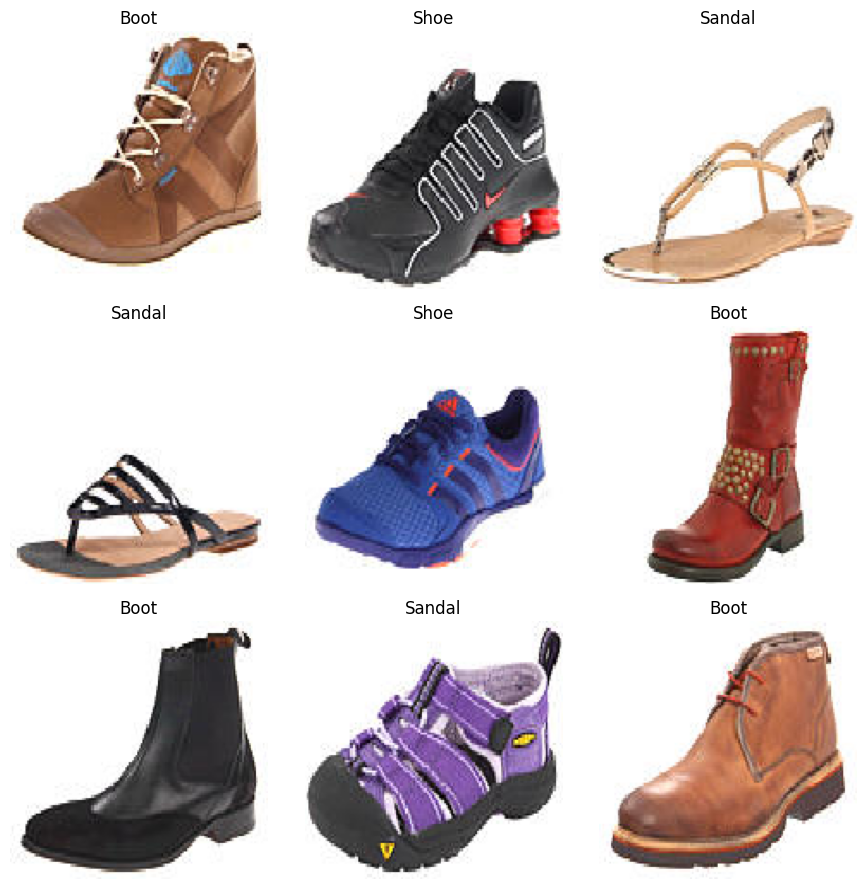

In [ ]:
def visualize_random_images(data_dir, img_size=(150, 150), num_images=9):
    classes = os.listdir(data_dir)
    images = []
    labels = []

    for _ in range(num_images):
        class_label = random.choice(classes)
        class_path = os.path.join(data_dir, class_label)

        if os.listdir(class_path):
            img_name = random.choice(os.listdir(class_path))
            img_path = os.path.join(class_path, img_name)

            img = load_img(img_path, target_size=img_size)
            images.append(img_to_array(img) / 255.0)
            labels.append(class_label)

    plt.figure(figsize=(9, 9))
    for i, img in enumerate(images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

dataset_dir = "./Shoe vs Sandal vs Boot Dataset/train"
visualize_random_images(dataset_dir, img_size=(150, 150))

Collecting random images from the data to display

# **Preprocessing**

In [ ]:
train_dir = "./Shoe vs Sandal vs Boot Dataset/train"
test_dir = "./Shoe vs Sandal vs Boot Dataset/test"

train_datagen = ImageDataGenerator( rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

The train data is split in train and val. The train, val and test set are normalized.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',

)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Training samples: 9600
Validation samples: 2400
Test samples: 3000


 The train,val and test are resized into 150*150 and encoded.

# **Building the model**

In [ ]:
def build_model(input_shape=(150, 150, 3), num_classes=3):
    model = models.Sequential()

    model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_model(input_shape=(150, 150, 3), num_classes=3)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,183,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,190,291 (4.54 MB)

 Trainable params: 1,190,291 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

# **Training the model**

In [ ]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(train_generator, batch_size=32, epochs=20, validation_data=val_generator, callbacks=[es_callback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 132s 433ms/step - accuracy: 0.7570 - loss: 0.5571 - val_accuracy: 0.9333 - val_loss: 0.1851
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 139s 423ms/step - accuracy: 0.9321 - loss: 0.1885 - val_accuracy: 0.9463 - val_loss: 0.1542
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 146s 435ms/step - accuracy: 0.9665 - loss: 0.1015 - val_accuracy: 0.9592 - val_loss: 0.1199
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 130s 432ms/step - accuracy: 0.9773 - loss: 0.0729 - val_accuracy: 0.9604 - val_loss: 0.1351
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 128s 425ms/step - accuracy: 0.9813 - loss: 0.0536 - val_accuracy: 0.9604 - val_loss: 0.1109
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 128s 427ms/step - accuracy: 0.9870 - loss: 0.0411 - val_accuracy: 0.9692 - val_loss: 0.0986
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 423ms/step - accuracy: 0.9944 - loss: 0.0164 - val_accuracy: 0.9621 - val_loss: 0.1300
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 130s 430ms/step - accuracy: 0.9941 - loss: 0.01

# **Experiment summary**

The best model is shown above with its validation accuracy being 0.9704.

Below is a summary of experiment run with different alterations to justify the model chosen above is right.

| MODEL | CHANGES MADE | VALIDATION ACCURACY |
|-------|--------------|---------------------|
|Model 1| Increased number of filters and kernel size | 0.9633 |
|Model 2| Increased the pooling size  |  0.9554 |
|Model 3| Added a dropout layer | 0.9696 |
|Model 4| Changed optimizer to SG and increased filters | 0.9696 |
|Model 5| Increased the learning rate and filters |  0.3333 |
|Model 6| Changed activation function to 'elu' and increase batch size |  0.3333 |
|Model 7| Reduced the number of neurons | 0.9588 |
|Model 8| Add batch normalization to each convolutional layer | 0.9146 |
| Model 9 |Added 2 dense layers and  changed the postion of the other dense layer | 0.9700|
|Model 10| Increased batch size | 0.9629 |
|Model 11 | Removed 2 convolutional and dense layers | 0.3288 |
 | Model 12 | Reduced the kernel size | 0.9692 |
 | Model 13| Removed a dense layer | 0.9663 |  

From the above validation scores, only Model 5, 6 and Model 11 had a huge drop. But the other models had some slight drops compared to the best model.




# **Testing the model**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


94/94 - 15s - 161ms/step - accuracy: 0.9720 - loss: 0.1463
Test Loss: 0.1463310271501541
Test Accuracy: 0.972000002861023


# **Conclusion**

**Pipeline Discussion**

In all, this is an image classification task with the purpose to train a model and classify them. This involves data loading, preprocessing, model building, training, experimenting with other models, testing and evaluation. This was all done using Keras and TensorFlow.

**Limitations**

*  Training models is time consumming.
*  Challenges with labelling between 'sparse' and 'categorical'.

**Strengths**

*  The ImageDataGenerator made it easier to resize, normalize and split into train and val.
*   Evaluating the model on a different test data after training prevents the overall performance from being biased.

**Implications**

*  Customers will recieve the right footwear which can increase customer satisfctory rate.
*  Less money spent on reshipping footwear.

**Recommendation**

*   Use deep learning to analyze customer preferences to recommend similar items.

**Informative features**

*   Categorical features to determine the type of footwear.
*   Visual features using the shape of the footwear.

In summary my model contains input images resized to 150*150 with each image having 3 channels representing the color images. It contains 3 layers and in each layer there is 1 convolutional amd pooling layer which extract features from images and reduce dimensions respectively. Followed by a flatten layer which flattens 3D feature yo 1D vector. Next are the dense and output dense layers which make predictions based on the features from the convolutional layers.


**Reference**

Kaggle:https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images/data



